Notes:
- West tower common area ventilation shut off from 2024-08-19, 9am - 2024-08-21, 9am

In [1]:
import datetime
import pandas as pd
import statsmodels.formula.api as sm
from functools import reduce
from typing import Sequence

In [60]:
def display_correlation(df: pd.DataFrame, tgt: str, src: str):
    regression = sm.ols(formula=f"{tgt} ~ {src} -0", data=df).fit()
    print(regression.params)
    [intercept, coefficient] = regression.params.values
    max_src = df[src].max()
    max_pred_tgt = max_src * coefficient + intercept
    ax = df.plot.scatter(tgt, src)
    ax.plot([intercept, max_pred_tgt], [0, max_src], color="0.9", linestyle="dotted")
    ax.text(x=2, y=0.5, s=f"{tgt} = {intercept:.4f} + {src} × {coefficient:.4f} (r²={regression.rsquared:.4f})")
    ax.set_xlim(left=0.25)

def display_data_and_correlations(
    df: pd.DataFrame, tgt: str, srcs: Sequence[str], start_incl: datetime.datetime, end_excl: datetime.datetime
):
    times = [start_incl + datetime.timedelta(hours=h) for h in range(int((end_excl - start_incl).total_seconds() / 60 / 60))]
    df_within_time = df.reset_index(level=0, drop=True).loc[times, :]
    df_grouped = df_within_time.groupby(["Floor", "Location"])
    dfs = [grp[["PM2.5(ug/m³)"]].rename(columns={"PM2.5(ug/m³)": f"L{floor}_{location.replace(" ", "_")}"}) for (floor, location), grp in df_grouped]
    pm25_df = reduce(lambda l, r: l.join(r), dfs)
    
    display(pm25_df)
    ax = pm25_df.resample("5min").interpolate(method="cubic").plot(ylabel="PM₂.₅ (µg/m³)")
    # Notes
    ax.text(x=start_incl + datetime.timedelta(hours=4.2), y=5, s="↖ Hallway ventilation back on")
    # for src in srcs:
    #     display_correlation(pm25_df, tgt, src)

In [61]:
%run "Common.ipynb"

PM2.5(ug/m³)  AQI  CO₂(ppm)  TVOC  \
Device Time                                                           
02     2024-08-21 04:00:00+08:00           5.2   29       593    51   
       2024-08-21 05:00:00+08:00           4.5   25       617    63   
       2024-08-21 06:00:00+08:00           4.4   25       647    53   
       2024-08-21 07:00:00+08:00           4.0   22       670    43   
       2024-08-21 08:00:00+08:00           4.0   22       682    36   
...                                        ...  ...       ...   ...   
03     2024-08-20 08:00:00+08:00           3.8   21       674    40   
       2024-08-20 09:00:00+08:00           4.1   23       667    41   
       2024-08-20 10:00:00+08:00          10.9   54       597    54   
       2024-08-20 11:00:00+08:00           9.1   51       610    57   
       2024-08-20 12:00:00+08:00           5.9   33       647    44   

                                  Temperature(℉)  Humidity(%RH) Floor  \
Device Time                                                             
02     2024-08-21 04:00:00+08:00            79.9             58     2   
       2024-08-21 05:00:00+08:00            79.7             58     2   
       2024-08-21 06:00:00+08:00            80.1             57     2   
       2024-08-21 07:00:00+08:00            80.1             57     2   
       2024-08-21 08:00:00+08:00            80.1             57     2   
...                                          ...            ...   ...   
03     2024-08-20 08:00:00+08:00            78.8             60     2   
       2024-08-20 09:00:00+08:00            78.8             61     2   
       2024-08-20 10:00:00+08:00            79.0             61     2   
       2024-08-20 11:00:00+08:00            76.5             55     2   
       2024-08-20 12:00:00+08:00            75.6             53     2   

                                      Location  
Device Time                                     
02     2024-08-21 04:00:00+08:00  West Hallway  
       2024-08-21 05:00:00+08:00  West Hallway  
       2024-08-21 06:00:00+08:00  West Hallway  
       2024-08-21 07:00:00+08:00  West Hallway  
       2024-08-21 08:00:00+08:00  West Hallway  
...                                        ...  
03     2024-08-20 08:00:00+08:00      Unit 210  
       2024-08-20 09:00:00+08:00      Unit 210  
       2024-08-20 10:00:00+08:00      Unit 210  
       2024-08-20 11:00:00+08:00      Unit 210  
       2024-08-20 12:00:00+08:00      Unit 210  

[199 rows x 8 columns]

,L2_Patio,L2_Unit_210,L2_West_Hallway
Time,,,
2024-08-21 04:00:00+08:00,6.8,7.5,5.2
2024-08-21 05:00:00+08:00,7.8,6.8,4.5
2024-08-21 06:00:00+08:00,9.3,6.8,4.4
2024-08-21 07:00:00+08:00,10.1,6.6,4.0
2024-08-21 08:00:00+08:00,20.5,6.9,4.0
2024-08-21 09:00:00+08:00,21.4,8.1,13.6
2024-08-21 10:00:00+08:00,25.6,11.1,21.1
2024-08-21 11:00:00+08:00,27.3,11.9,30.2


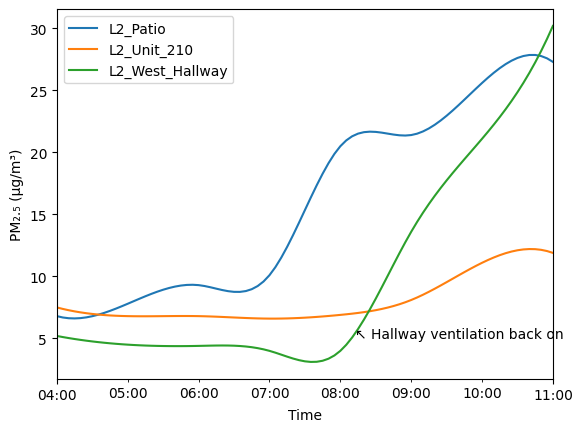

In [62]:
start_incl = datetime.datetime.fromisoformat("2024-08-21T04:00:00+08.00")
end_excl = datetime.datetime.fromisoformat("2024-08-21T12:00:00+08.00")

display_data_and_correlations(df, "L2_Patio", ["L2_Unit_210", "L2_West_Hallway"], start_incl, end_excl)